<a href="https://colab.research.google.com/github/apondi-911/CNN_Models/blob/main/CNNEndoModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Setup and Load Data**

####Connecting Google colab with GoogleDrive

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Installing the necessary libraries

In [126]:
import os
import numpy as np
import cv2
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,BatchNormalization,Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy



####Checking list of Directories in the Dataset

In [127]:
data_dir='/content/drive/MyDrive/Data'
os.listdir(data_dir)

['Other_Images', 'no_pathology', 'pathology']

####Testing Whether the directories contain the Images

In [128]:
img=cv2.imread(os.path.join('/content/drive/MyDrive/Data/no_pathology/f_1.jpg'))
img.shape

(360, 640, 3)

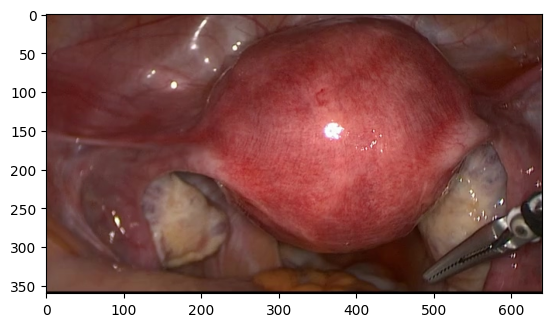

In [129]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

# 1.**Load Data**


In [130]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 4913 files belonging to 3 classes.


In [131]:
tf.random.set_seed(0)

In [132]:
class_names=data.class_names 
class_names

['Other_Images', 'no_pathology', 'pathology']

###Displaying Number of Images in each class


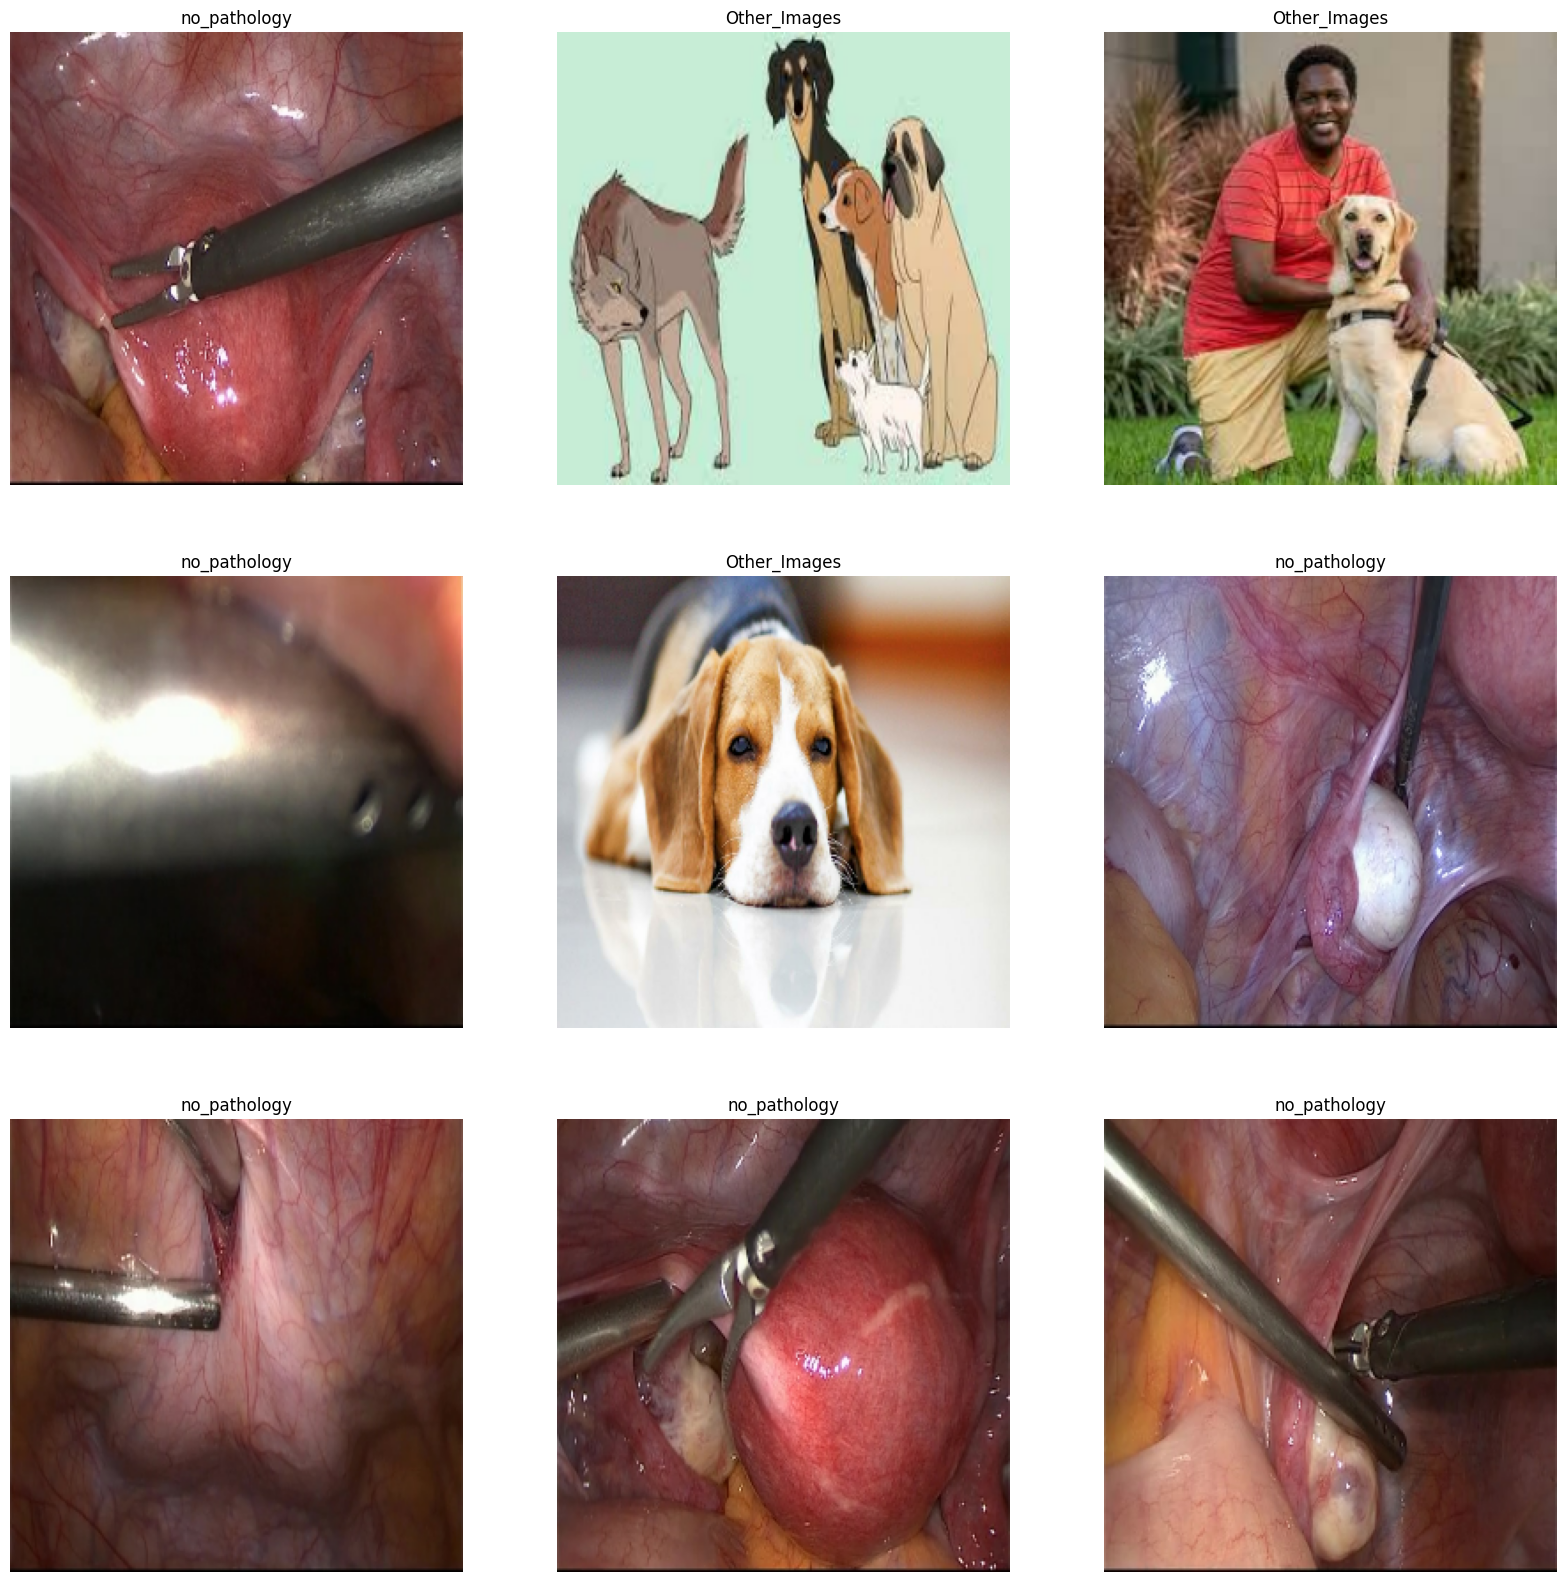

In [133]:
plt.figure(figsize=(20, 20))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(np.argmax(labels[i]))])
    plt.axis("off")
plt.show()

In [121]:

# # Define your dataset
# data_dir = '/content/drive/MyDrive/Data'
# data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

# # Get the class names
# class_names = ['Other_Images', 'pathology', 'no_pathology']

# # Count the number of files in each class
# for class_name in class_names:
#     class_dir = os.path.join(data_dir, class_name)
#     class_files = os.listdir(class_dir)
#     num_files = len(class_files)
#     print(f'Class {class_name} has {num_files} files.')

# **2. Data Pre-processing and augmentation**



### 2.1 Augmenting the data

This involves rotation and flipping our images from the dataset so as to increase the number to obtain better results.

In [134]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1)
])

In [135]:
aug_ds = data.map(lambda x, y: (data_augmentation(x), y), 
                num_parallel_calls=tf.data.AUTOTUNE)

### 2.2 Displaying the augmented the data

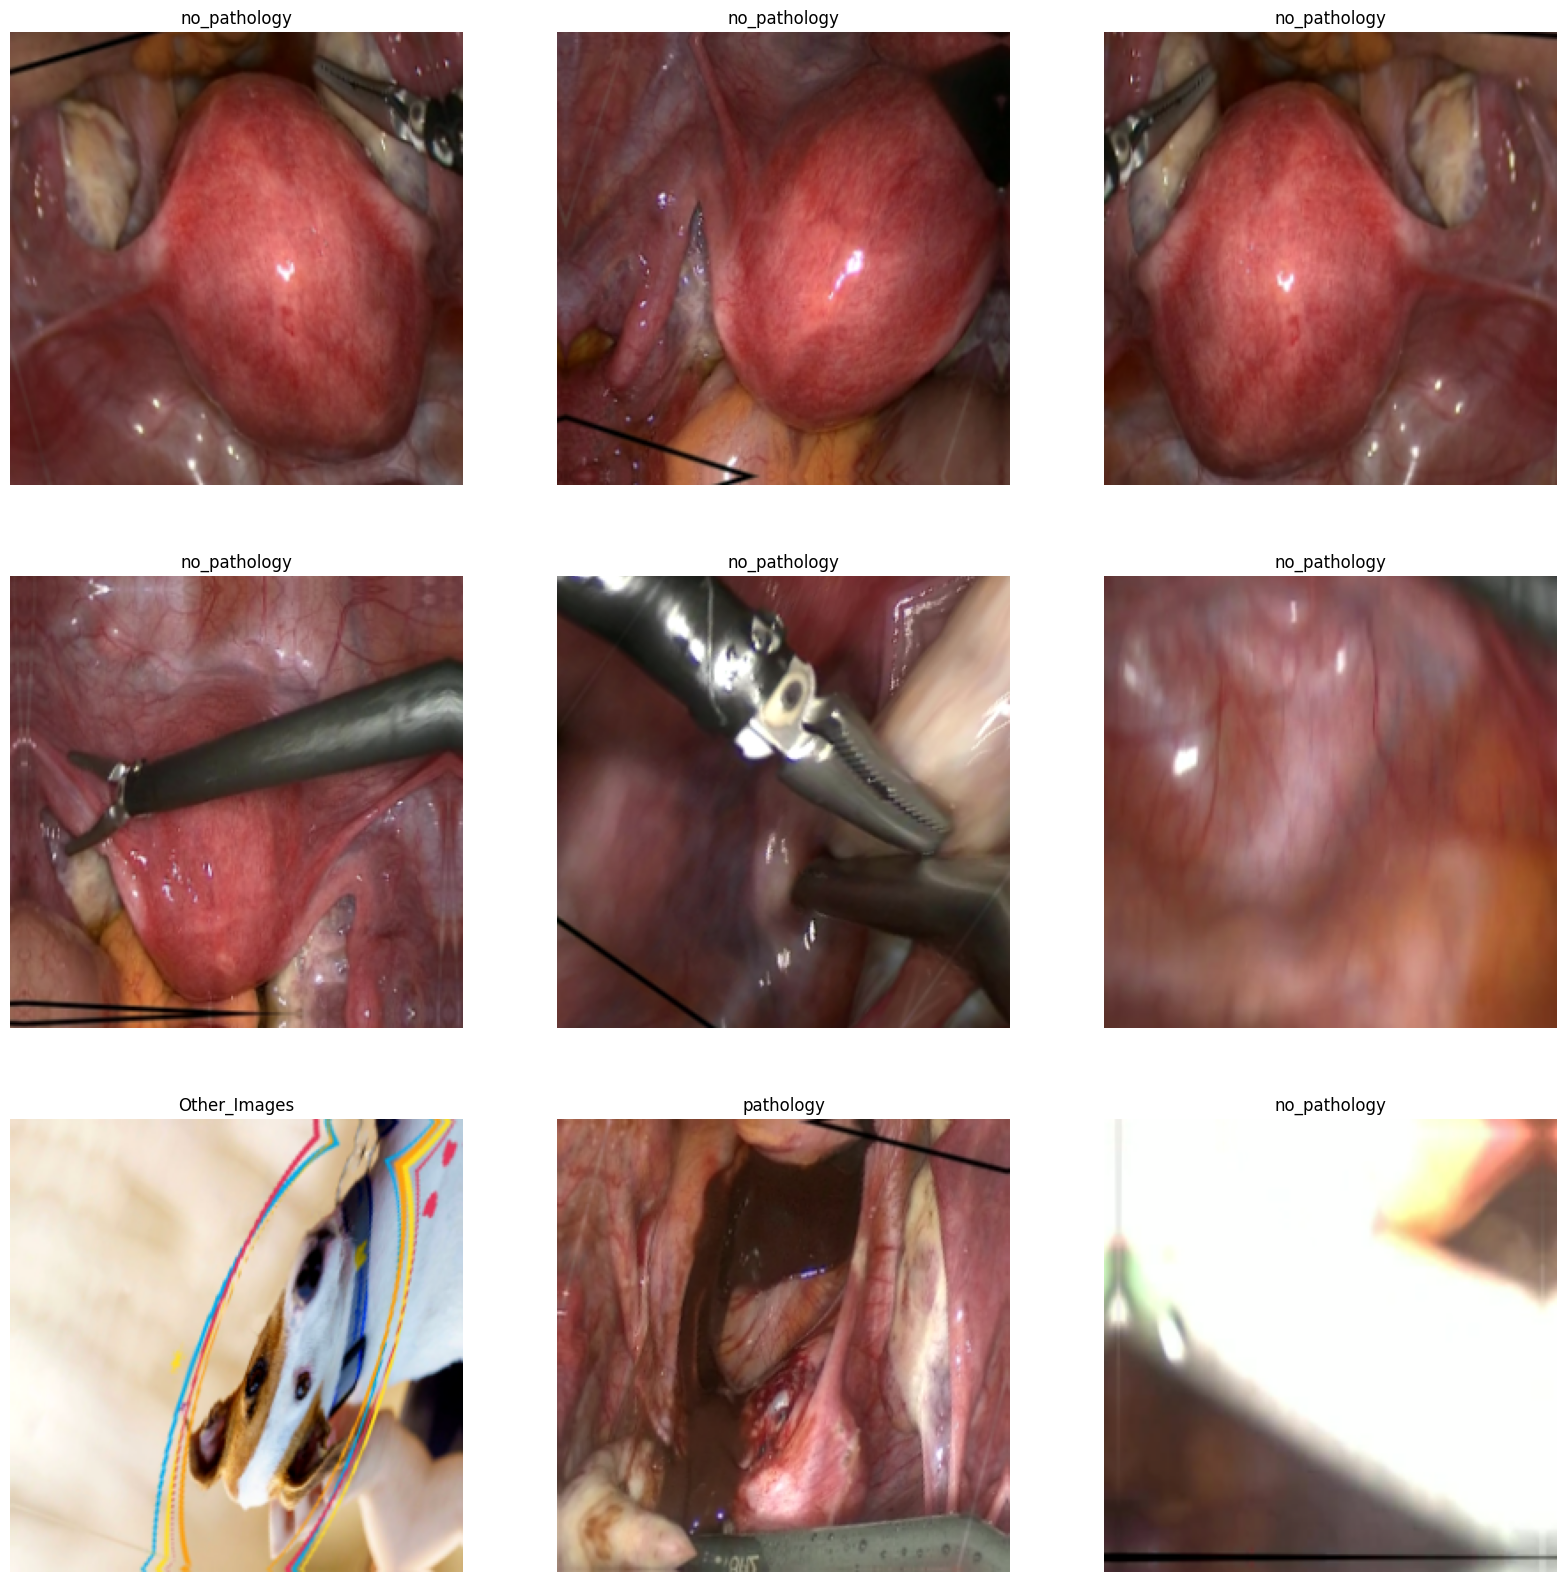

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in aug_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(np.argmax(labels[i]))])
    plt.axis("off")
plt.show()

### 2.3 Feature Scaling data

####Scaling the Augmented Images

#####The main goal of scaling is to ensure that each feature of the data has a similar scale or range of values, typically between 0 and 1.It can improve the performance of the model, reduce overfitting, and help avoid convergence issues during training.

In [137]:
aug_ds= aug_ds.map(lambda x, y:(x/255,y))

In [138]:
len(aug_ds)

154

##**2.4 Split Data** 

In [139]:
train_size = int(len(aug_ds) * 0.7)
val_size = int(len(aug_ds) * 0.2)
test_size = int(len(aug_ds) * 0.1)

In [140]:
test_size

15

In [141]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(val_size)

In [142]:
len(val)

30

# **3. Deep Learning Model (CNN)**

### 3.1. Build Deep Learning Model

#### Used to display a linear stack of layers in a neural network.

In [143]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
BatchNormalization()
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
BatchNormalization()
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
BatchNormalization()
model.add(Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
BatchNormalization()
model.add(Dropout(0.2))

# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# BatchNormalization()
# model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation ='relu'))
model.add(Dense(64, activation ='relu'))
model.add(Dense(32, activation ='relu'))
model.add(Dense(3, activation="softmax"))


In [144]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 62, 62, 32)       

### Compilation is a crucial step in setting up a deep learning model.It is used to configure the model for training.
#### Optimizer-adam, loss-function-SparseCategoricalCrossentropy and a metrics-accuracy to evaluate performance during testing and training.

In [145]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

#### Summary displays the architecture of the model. It displays a table with layer name, output shape and number of parameters.
#### The summary shows the total number of trainable and non-trainable parameters in the model.

In [146]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 62, 62, 32)       

### 3.2.Train 

In [147]:
tf.keras.callbacks.Callback()

In [148]:
logdir = '/logs'

In [155]:
tensorboard_callback =tf.keras.callbacks.TensorBoard(log_dir = logdir)
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

####This is where training happens it takes its inputs as training data, validation data and other hyperparameters like epochs

In [156]:
hist= model.fit(train, epochs =5, batch_size=32,validation_data =val, callbacks=[tensorboard_callback,es]) 

Epoch 1/5
107/107 [==============================] - 30s 269ms/step - loss: 0.1230 - accuracy: 0.9670 - val_loss: 0.3523 - val_accuracy: 0.9083
Epoch 2/5
107/107 [==============================] - 30s 267ms/step - loss: 0.1084 - accuracy: 0.9690 - val_loss: 0.1626 - val_accuracy: 0.9542
Epoch 3/5
107/107 [==============================] - 29s 267ms/step - loss: 0.0729 - accuracy: 0.9772 - val_loss: 0.1305 - val_accuracy: 0.9698
Epoch 4/5
107/107 [==============================] - 30s 280ms/step - loss: 0.1586 - accuracy: 0.9655 - val_loss: 0.1776 - val_accuracy: 0.9490
Epoch 5/5
107/107 [==============================] - 29s 266ms/step - loss: 0.0767 - accuracy: 0.9737 - val_loss: 0.1483 - val_accuracy: 0.9604


In [157]:
img = cv2.imread('/content/drive/MyDrive/Data/pathology/f_29.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img,(256,256))
image = np.expand_dims(resize,0)
pred = model.predict(image)
pred

1/1 [==============================] - 0s 21ms/step


array([[0.02091863, 0.01414316, 0.96493816]], dtype=float32)

In [158]:
print(np.argmax(pred))

2


### 3.3 Plot Perfomance

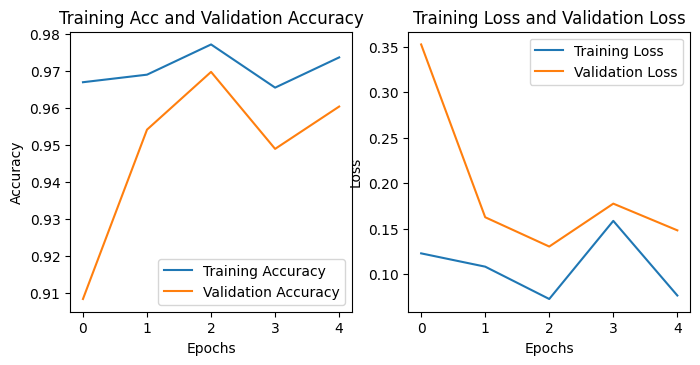

In [185]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Acc and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# **4. Testing**

In [160]:
test_loss, test_acc =model.evaluate(test,verbose=2)
print("\n Test Accuracy: ", test_acc)

17/17 - 16s - loss: 0.1779 - accuracy: 0.9565 - 16s/epoch - 930ms/step

 Test Accuracy:  0.95652174949646


##4.1 Metrics Performance

In [161]:
pre = Precision()
re = Recall()
acc =BinaryAccuracy()

In [162]:
for batch in test.as_numpy_iterator():
  X, y= batch
  yhat = model.predict(X)
  yhat = np.argmax(yhat, axis=-1)
  y = np.argmax(y, axis=-1)
  # y = y.reshape(-1)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)
  # f1score.update_state(y,yhat)


1/1 [==============================] - 0s 24ms/step


In [163]:
f1_score = 2 * (pre.result().numpy() * re.result().numpy()) / (pre.result().numpy() + re.result().numpy())

In [165]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}, f1_score:{f1_score}')

Precision:0.995604395866394, Recall:0.9847826361656189, Accuracy:0.8166351318359375, f1_score:0.9901639650171044


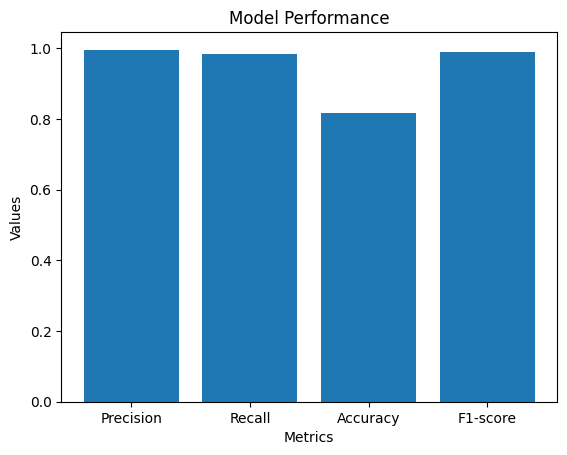

In [166]:
# Define the metrics and their values
metrics = ['Precision', 'Recall', 'Accuracy', 'F1-score']
values = [pre.result().numpy(), re.result().numpy(), acc.result().numpy(), f1_score]

# Create a bar plot
plt.bar(metrics, values)

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance')

# Show the plot
plt.show()

In [167]:
from sklearn.metrics import confusion_matrix

for batch in test.as_numpy_iterator():
  X, y= batch
  y_pred = model.predict(X)
  y_pred = np.argmax(y_pred, axis=1)
  y = np.argmax(y, axis=-1)
  cm = confusion_matrix(y, y_pred)
  print(cm)


1/1 [==============================] - 0s 85ms/step
[[ 9  0  0]
 [ 0 18  0]
 [ 0  0  5]]
1/1 [==============================] - 0s 122ms/step
[[ 3  0  0]
 [ 1 25  0]
 [ 0  0  3]]
1/1 [==============================] - 0s 76ms/step
[[ 3  0  0]
 [ 2 18  0]
 [ 0  2  7]]
1/1 [==============================] - 0s 164ms/step
[[ 5  0  0]
 [ 0 18  0]
 [ 0  1  8]]
1/1 [==============================] - 0s 103ms/step
[[ 3  0  0]
 [ 0 24  0]
 [ 0  0  5]]
1/1 [==============================] - 0s 100ms/step
[[ 7  0  0]
 [ 0 24  0]
 [ 0  0  1]]
1/1 [==============================] - 0s 44ms/step
[[ 6  0  0]
 [ 1 20  0]
 [ 0  0  5]]
1/1 [==============================] - 0s 54ms/step
[[ 6  0  0]
 [ 2 18  1]
 [ 1  1  3]]
1/1 [==============================] - 0s 40ms/step
[[ 3  0  0]
 [ 0 23  1]
 [ 0  0  5]]
1/1 [==============================] - 0s 43ms/step
[[ 3  0  0]
 [ 1 23  1]
 [ 0  0  4]]
1/1 [==============================] - 0s 38ms/step
[[ 2  0  0]
 [ 0 20  0]
 [ 0  2  8]]
1/1 [============

1/1 [==============================] - 0s 41ms/step


<Axes: >

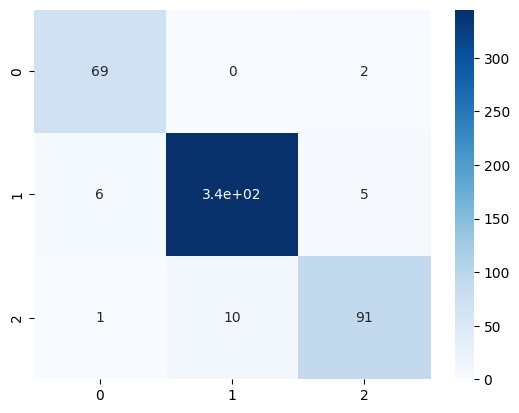

In [168]:
from sklearn.metrics import confusion_matrix

# Initialize empty arrays to accumulate the predictions and true labels
y_pred_all = []
y_true_all = []

# Loop over all batches in the test data
for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=-1)
    
    # Accumulate the predictions and true labels for each batch
    y_pred_all.append(y_pred)
    y_true_all.append(y_true)
    
# Concatenate the predictions and true labels from all batches
y_pred_all = np.concatenate(y_pred_all)
y_true_all = np.concatenate(y_true_all)

# Generate a single confusion matrix for all the test data
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot the confusion matrix as a heatmap using Seaborn

sns.heatmap(cm, annot=True, cmap='Blues')



In [169]:
model.save(os.path.join('/content/drive/MyDrive/model','model.h5'))

### 4.1 **Test Sample**

In [170]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model.h5')


1/1 [==============================] - 0s 21ms/step


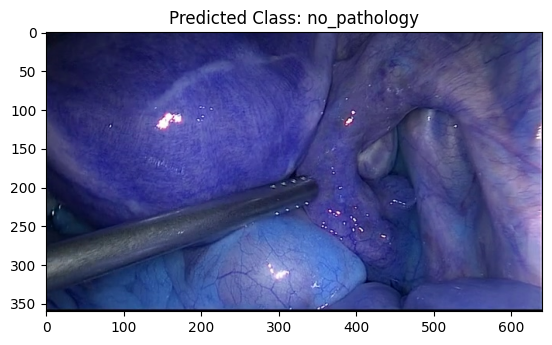

In [171]:
img = cv2.imread('/content/drive/MyDrive/Data/no_pathology/f_1002.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img,(256,256))
image = np.expand_dims(resize,0)
pred = model.predict(image)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Predicted Class: {}'.format(class_names[np.argmax(pred)]))
plt.show()

In [52]:
pred = model.predict(image)
class_index = np.argmax(pred)
class_name = class_names[class_index]
print('Predicted class name: ', class_name)


1/1 [==============================] - 0s 19ms/step
Predicted class name:  no_pathology


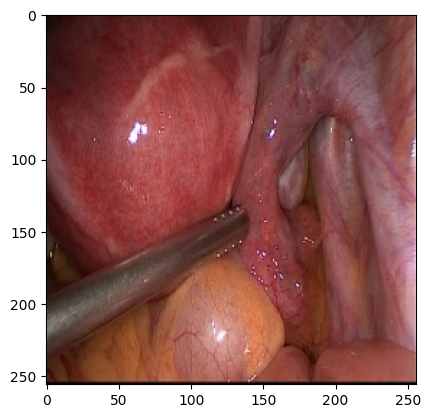

In [172]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [173]:
resize

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[ 34.64453   ,  20.644531  ,  20.644531  ],
        [ 27.539062  ,  14.7890625 ,  15.5390625 ],
        [ 28.        ,  12.25      ,  13.75      ],
        ...,
        [127.4375    ,  76.9375    ,  72.9375    ],
        [131.28906   ,  82.28906   ,  78.28906   ],
        [137.67578   ,  89.67578   ,  85.67578   ]],

       [[ 34.01172   ,  20.011719  ,  20.011719  ],
        [ 23.988281  ,  12.152344  ,  11.53125   ],
        [ 27.390625  ,  11.792969  ,  12.8359375 ],
        ...,
        [124.09766   ,  73.29297   ,  69.44531   ],
        [129.71875   ,  80.41406   ,  76.56641   ],
        [148.51562   ,  99.90625   ,  95.90625   ]],

       [[ 38.23047   ,  24.277344  ,  24.246094  ],
        [ 24.992188  ,  13.746094  ,  12.238281  ],
        [ 26.003906  ,  11.0078125 ,  11.738281  ],
        ...,
        [124.328125  ,  73.30469   ,  69.55469   ],
        [131.27344   ,  81.77344   ,  78.02344   ],
        [150.92578

In [174]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [175]:
yhat= model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 27ms/step


In [176]:
(yhat)*100

array([[11.647233, 56.647293, 31.705475]], dtype=float32)

# **5. Save Model**

### **5.1 Save Model**

In [177]:
from tensorflow.keras.models import load_model

In [178]:
model.save(os.path.join('/content/drive/MyDrive/model','model.h5'))

In [182]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model.h5')


In [181]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))


1/1 [==============================] - 0s 18ms/step
